In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=200 # Number of kernels in convolutional network
kernel_size1=3
strides=1
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating input dataset - mask
mask_dir = main_directory + '\\aeroCNN2Mask'
os.chdir(mask_dir)
mask_list = os.listdir(mask_dir)
mask_target = [file for file in mask_list if file.endswith('.csv')]

In [8]:
mask_df = pd.DataFrame()
for file in mask_target:
    data = pd.read_csv(file, header=None)
    mask_df = pd.concat([mask_df, data], axis=0)

In [9]:
x = mask_df.iloc[:,:].values

In [10]:
x_alligned = np.zeros((x.shape[0],x.shape[1]))
for i in range(0,144*2):
    if i%2==0:
        x_alligned[i*100:(i+1)*100,:] = x[i*100:(i+1)*100,:]
    else:
        x_alligned[i*100:(i+1)*100,:] = x[i*100:(i+1)*100,:].T


In [11]:
x = x_alligned.reshape((16*9,2,input_size,input_size))

In [12]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]
os.chdir(main_directory)

In [13]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [14]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [15]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [16]:
y.shape

(144, 2)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [18]:
x_train.shape

(129, 2, 100, 100)

In [19]:
y_train.shape

(129, 2)

In [20]:
tf.keras.backend.set_image_data_format('channels_first')

In [21]:
input_image = tf.keras.Input(shape=(2, input_size, input_size))

x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_flat = tf.keras.layers.Flatten()(x_)
x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_flat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=16, activation='relu', name='fc4')(x_fc3)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc4)
# AeroCNN-II based
model = tf.keras.Model(input_image, output_data)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 100, 100)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 100, 100)     3800      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 200, 50, 50)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 500000)            0         
                                                                 
 fc1 (Dense)                 (None, 128)               64000128  
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                             

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [24]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=100, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [25]:
STEP_SIZE_TRAIN = len(x_train)//batch_size

In [26]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
6/6 [==============================] - 4s 207ms/step - loss: 604.3260 - rmse: 24.5830 - lr: 0.0010
Epoch 2/5000
6/6 [==============================] - 0s 42ms/step - loss: 32.1317 - rmse: 5.6685 - lr: 0.0010
Epoch 3/5000
6/6 [==============================] - 0s 46ms/step - loss: 14.1095 - rmse: 3.7563 - lr: 0.0010
Epoch 4/5000
6/6 [==============================] - 0s 47ms/step - loss: 4.7361 - rmse: 2.1763 - lr: 0.0010
Epoch 5/5000
6/6 [==============================] - 0s 46ms/step - loss: 4.2227 - rmse: 2.0549 - lr: 0.0010
Epoch 6/5000
6/6 [==============================] - 0s 47ms/step - loss: 2.8314 - rmse: 1.6827 - lr: 0.0010
Epoch 7/5000
6/6 [==============================] - 0s 46ms/step - loss: 2.4281 - rmse: 1.5582 - lr: 0.0010
Epoch 8/5000
6/6 [==============================] - 0s 48ms/step - loss: 1.6872 - rmse: 1.2989 - lr: 0.0010
Epoch 9/5000
6/6 [==============================] - 0s 47ms/step - loss: 1.0780 - rmse: 1.0383 - lr: 0.0010
Epoch 10/5000
6/6 [===

6/6 [==============================] - 0s 11ms/step - loss: 0.0453 - rmse: 0.2128 - lr: 0.0010
Epoch 77/5000
6/6 [==============================] - 0s 34ms/step - loss: 0.0183 - rmse: 0.1352 - lr: 0.0010
Epoch 78/5000
6/6 [==============================] - 0s 41ms/step - loss: 0.0153 - rmse: 0.1238 - lr: 0.0010
Epoch 79/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0176 - rmse: 0.1326 - lr: 0.0010
Epoch 80/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0163 - rmse: 0.1277 - lr: 0.0010
Epoch 81/5000
6/6 [==============================] - 0s 42ms/step - loss: 0.0128 - rmse: 0.1129 - lr: 0.0010
Epoch 82/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0146 - rmse: 0.1210 - lr: 0.0010
Epoch 83/5000
6/6 [==============================] - 0s 40ms/step - loss: 0.0123 - rmse: 0.1107 - lr: 0.0010
Epoch 84/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0174 - rmse: 0.1320 - lr: 0.0010
Epoch 85/5000
6/6 [==============

6/6 [==============================] - 0s 11ms/step - loss: 0.0254 - rmse: 0.1595 - lr: 0.0010
Epoch 151/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0180 - rmse: 0.1341 - lr: 0.0010
Epoch 152/5000
6/6 [==============================] - 0s 36ms/step - loss: 0.0102 - rmse: 0.1012 - lr: 0.0010
Epoch 153/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0106 - rmse: 0.1027 - lr: 0.0010
Epoch 154/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0141 - rmse: 0.1188 - lr: 0.0010
Epoch 155/5000
6/6 [==============================] - 0s 12ms/step - loss: 0.0106 - rmse: 0.1030 - lr: 0.0010
Epoch 156/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0151 - rmse: 0.1230 - lr: 0.0010
Epoch 157/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0316 - rmse: 0.1778 - lr: 0.0010
Epoch 158/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0304 - rmse: 0.1745 - lr: 0.0010
Epoch 159/5000
6/6 [=====

6/6 [==============================] - 0s 42ms/step - loss: 0.0046 - rmse: 0.0677 - lr: 0.0010
Epoch 225/5000
6/6 [==============================] - 0s 42ms/step - loss: 0.0042 - rmse: 0.0646 - lr: 0.0010
Epoch 226/5000
6/6 [==============================] - 0s 12ms/step - loss: 0.0095 - rmse: 0.0977 - lr: 0.0010
Epoch 227/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0085 - rmse: 0.0919 - lr: 0.0010
Epoch 228/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 0.0010
Epoch 229/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0091 - rmse: 0.0954 - lr: 0.0010
Epoch 230/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0099 - rmse: 0.0995 - lr: 0.0010
Epoch 231/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0133 - rmse: 0.1153 - lr: 0.0010
Epoch 232/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0136 - rmse: 0.1168 - lr: 0.0010
Epoch 233/5000
6/6 [=====

6/6 [==============================] - 0s 11ms/step - loss: 0.1775 - rmse: 0.4213 - lr: 0.0010
Epoch 299/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.1280 - rmse: 0.3578 - lr: 0.0010
Epoch 300/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.1174 - rmse: 0.3426 - lr: 0.0010
Epoch 301/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0687 - rmse: 0.2621 - lr: 0.0010
Epoch 302/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0412 - rmse: 0.2030 - lr: 0.0010
Epoch 303/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0456 - rmse: 0.2136 - lr: 0.0010
Epoch 304/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0394 - rmse: 0.1984 - lr: 0.0010
Epoch 305/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0198 - rmse: 0.1406 - lr: 0.0010
Epoch 306/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0301 - rmse: 0.1736 - lr: 0.0010
Epoch 307/5000
6/6 [=====

6/6 [==============================] - 0s 11ms/step - loss: 0.0205 - rmse: 0.1432 - lr: 0.0010
Epoch 373/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0103 - rmse: 0.1017 - lr: 0.0010
Epoch 374/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0109 - rmse: 0.1044 - lr: 0.0010
Epoch 375/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0145 - rmse: 0.1204 - lr: 0.0010
Epoch 376/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0071 - rmse: 0.0843 - lr: 0.0010
Epoch 377/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0079 - rmse: 0.0890 - lr: 0.0010
Epoch 378/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0069 - rmse: 0.0832 - lr: 0.0010
Epoch 379/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0068 - rmse: 0.0824 - lr: 0.0010
Epoch 380/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0053 - rmse: 0.0727 - lr: 0.0010
Epoch 381/5000
6/6 [=====

6/6 [==============================] - 0s 36ms/step - loss: 8.8765e-04 - rmse: 0.0298 - lr: 0.0010
Epoch 447/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0332 - lr: 0.0010
Epoch 448/5000
6/6 [==============================] - 0s 11ms/step - loss: 9.9067e-04 - rmse: 0.0315 - lr: 0.0010
Epoch 449/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0318 - lr: 0.0010
Epoch 450/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0317 - lr: 0.0010
Epoch 451/5000
6/6 [==============================] - 0s 11ms/step - loss: 9.3995e-04 - rmse: 0.0307 - lr: 0.0010
Epoch 452/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0365 - lr: 0.0010
Epoch 453/5000
6/6 [==============================] - 0s 42ms/step - loss: 8.4320e-04 - rmse: 0.0290 - lr: 0.0010
Epoch 454/5000
6/6 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0347 - lr: 0.0010
Epoch 455

6/6 [==============================] - 0s 11ms/step - loss: 5.8287e-04 - rmse: 0.0241 - lr: 0.0010
Epoch 519/5000
6/6 [==============================] - 0s 11ms/step - loss: 5.7447e-04 - rmse: 0.0240 - lr: 0.0010
Epoch 520/5000
6/6 [==============================] - 0s 36ms/step - loss: 3.7686e-04 - rmse: 0.0194 - lr: 0.0010
Epoch 521/5000
6/6 [==============================] - 0s 11ms/step - loss: 6.2236e-04 - rmse: 0.0249 - lr: 0.0010
Epoch 522/5000
6/6 [==============================] - 0s 11ms/step - loss: 6.5545e-04 - rmse: 0.0256 - lr: 0.0010
Epoch 523/5000
6/6 [==============================] - 0s 43ms/step - loss: 3.7379e-04 - rmse: 0.0193 - lr: 0.0010
Epoch 524/5000
6/6 [==============================] - 0s 11ms/step - loss: 5.3959e-04 - rmse: 0.0232 - lr: 0.0010
Epoch 525/5000
6/6 [==============================] - 0s 11ms/step - loss: 5.0026e-04 - rmse: 0.0224 - lr: 0.0010
Epoch 526/5000
6/6 [==============================] - 0s 11ms/step - loss: 5.1973e-04 - rmse: 0.0228 - 

Epoch 590/5000
6/6 [==============================] - 0s 11ms/step - loss: 4.0093e-04 - rmse: 0.0200 - lr: 0.0010
Epoch 591/5000
6/6 [==============================] - 0s 11ms/step - loss: 4.6355e-04 - rmse: 0.0215 - lr: 0.0010
Epoch 592/5000
6/6 [==============================] - 0s 11ms/step - loss: 3.8080e-04 - rmse: 0.0195 - lr: 0.0010
Epoch 593/5000
6/6 [==============================] - 0s 11ms/step - loss: 4.4594e-04 - rmse: 0.0211 - lr: 0.0010
Epoch 594/5000
6/6 [==============================] - 0s 11ms/step - loss: 2.9479e-04 - rmse: 0.0172 - lr: 0.0010
Epoch 595/5000
6/6 [==============================] - 0s 11ms/step - loss: 4.6136e-04 - rmse: 0.0215 - lr: 0.0010
Epoch 596/5000
6/6 [==============================] - 0s 11ms/step - loss: 3.5220e-04 - rmse: 0.0188 - lr: 0.0010
Epoch 597/5000
6/6 [==============================] - 0s 11ms/step - loss: 4.0486e-04 - rmse: 0.0201 - lr: 0.0010
Epoch 598/5000
6/6 [==============================] - 0s 11ms/step - loss: 3.2922e-04 - 

6/6 [==============================] - 0s 11ms/step - loss: 6.3491e-04 - rmse: 0.0252 - lr: 0.0010
Epoch 663/5000
6/6 [==============================] - 0s 11ms/step - loss: 5.2971e-04 - rmse: 0.0230 - lr: 0.0010
Epoch 664/5000
6/6 [==============================] - 0s 11ms/step - loss: 6.0724e-04 - rmse: 0.0246 - lr: 0.0010
Epoch 665/5000
6/6 [==============================] - 0s 11ms/step - loss: 6.6682e-04 - rmse: 0.0258 - lr: 0.0010
Epoch 666/5000
6/6 [==============================] - 0s 11ms/step - loss: 5.7574e-04 - rmse: 0.0240 - lr: 0.0010
Epoch 667/5000
6/6 [==============================] - 0s 11ms/step - loss: 4.7823e-04 - rmse: 0.0219 - lr: 0.0010
Epoch 668/5000
6/6 [==============================] - 0s 11ms/step - loss: 4.2266e-04 - rmse: 0.0206 - lr: 0.0010
Epoch 669/5000
6/6 [==============================] - 0s 11ms/step - loss: 3.4628e-04 - rmse: 0.0186 - lr: 0.0010
Epoch 670/5000
6/6 [==============================] - 0s 11ms/step - loss: 3.9999e-04 - rmse: 0.0200 - 

Epoch 731/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.2863e-04 - rmse: 0.0113 - lr: 5.0000e-04
Epoch 732/5000
6/6 [==============================] - 0s 11ms/step - loss: 2.5293e-04 - rmse: 0.0159 - lr: 5.0000e-04
Epoch 733/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.9143e-04 - rmse: 0.0138 - lr: 5.0000e-04
Epoch 734/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.8847e-04 - rmse: 0.0137 - lr: 5.0000e-04
Epoch 735/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.5471e-04 - rmse: 0.0124 - lr: 5.0000e-04
Epoch 736/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.4546e-04 - rmse: 0.0121 - lr: 5.0000e-04
Epoch 737/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.7979e-04 - rmse: 0.0134 - lr: 5.0000e-04
Epoch 738/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.7560e-04 - rmse: 0.0133 - lr: 5.0000e-04
Epoch 739/5000
6/6 [==============================] - 0s

6/6 [==============================] - 0s 11ms/step - loss: 1.2393e-04 - rmse: 0.0111 - lr: 5.0000e-04
Epoch 801/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.9685e-04 - rmse: 0.0140 - lr: 5.0000e-04
Epoch 802/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.6829e-04 - rmse: 0.0130 - lr: 5.0000e-04
Epoch 803/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.5234e-04 - rmse: 0.0123 - lr: 5.0000e-04
Epoch 804/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.4190e-04 - rmse: 0.0119 - lr: 5.0000e-04
Epoch 805/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.7939e-04 - rmse: 0.0134 - lr: 5.0000e-04
Epoch 806/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.7148e-04 - rmse: 0.0131 - lr: 5.0000e-04
Epoch 807/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.7178e-04 - rmse: 0.0131 - lr: 5.0000e-04
Epoch 808/5000
6/6 [==============================] - 0s 11ms/step - lo

6/6 [==============================] - ETA: 0s - loss: 2.6859e-04 - rmse: 0.0164
Epoch 869: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
6/6 [==============================] - 0s 11ms/step - loss: 2.6859e-04 - rmse: 0.0164 - lr: 5.0000e-04
Epoch 870/5000
6/6 [==============================] - 0s 11ms/step - loss: 2.2295e-04 - rmse: 0.0149 - lr: 2.5000e-04
Epoch 871/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.1475e-04 - rmse: 0.0107 - lr: 2.5000e-04
Epoch 872/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.9846e-04 - rmse: 0.0141 - lr: 2.5000e-04
Epoch 873/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.1316e-04 - rmse: 0.0106 - lr: 2.5000e-04
Epoch 874/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.1389e-04 - rmse: 0.0107 - lr: 2.5000e-04
Epoch 875/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.3849e-04 - rmse: 0.0118 - lr: 2.5000e-04
Epoch 876/5000
6/6 [==========

6/6 [==============================] - 0s 11ms/step - loss: 1.0220e-04 - rmse: 0.0101 - lr: 2.5000e-04
Epoch 938/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.4177e-04 - rmse: 0.0119 - lr: 2.5000e-04
Epoch 939/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.0114e-04 - rmse: 0.0101 - lr: 2.5000e-04
Epoch 940/5000
6/6 [==============================] - 0s 11ms/step - loss: 2.2412e-04 - rmse: 0.0150 - lr: 2.5000e-04
Epoch 941/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.5869e-04 - rmse: 0.0126 - lr: 2.5000e-04
Epoch 942/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.9286e-04 - rmse: 0.0139 - lr: 2.5000e-04
Epoch 943/5000
6/6 [==============================] - 0s 11ms/step - loss: 9.1892e-05 - rmse: 0.0096 - lr: 2.5000e-04
Epoch 944/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.6056e-04 - rmse: 0.0127 - lr: 2.5000e-04
Epoch 945/5000
6/6 [==============================] - 0s 11ms/step - lo

6/6 [==============================] - 0s 11ms/step - loss: 1.5275e-04 - rmse: 0.0124 - lr: 2.5000e-04
Epoch 1007/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.9047e-04 - rmse: 0.0138 - lr: 2.5000e-04
Epoch 1008/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.3314e-04 - rmse: 0.0115 - lr: 2.5000e-04
Epoch 1009/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.5338e-04 - rmse: 0.0124 - lr: 2.5000e-04
Epoch 1010/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.9288e-04 - rmse: 0.0139 - lr: 2.5000e-04
Epoch 1011/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.7744e-04 - rmse: 0.0133 - lr: 2.5000e-04
Epoch 1012/5000
6/6 [==============================] - 0s 11ms/step - loss: 8.1227e-05 - rmse: 0.0090 - lr: 2.5000e-04
Epoch 1013/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.8397e-04 - rmse: 0.0136 - lr: 2.5000e-04
Epoch 1014/5000
6/6 [==============================] - 0s 11ms/s

Epoch 1075/5000
6/6 [==============================] - 0s 11ms/step - loss: 2.1454e-04 - rmse: 0.0146 - lr: 2.5000e-04
Epoch 1076/5000
6/6 [==============================] - 0s 11ms/step - loss: 7.0494e-05 - rmse: 0.0084 - lr: 2.5000e-04
Epoch 1077/5000
6/6 [==============================] - 0s 11ms/step - loss: 2.4898e-04 - rmse: 0.0158 - lr: 2.5000e-04
Epoch 1078/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.0008e-04 - rmse: 0.0100 - lr: 2.5000e-04
Epoch 1079/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.4633e-04 - rmse: 0.0121 - lr: 2.5000e-04
Epoch 1080/5000
6/6 [==============================] - 0s 11ms/step - loss: 2.1849e-04 - rmse: 0.0148 - lr: 2.5000e-04
Epoch 1081/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.6725e-04 - rmse: 0.0129 - lr: 2.5000e-04
Epoch 1082/5000
6/6 [==============================] - 0s 11ms/step - loss: 1.7699e-04 - rmse: 0.0133 - lr: 2.5000e-04
Epoch 1083/5000
6/6 [===========================

Epoch 1144/5000
6/6 [==============================] - 0s 11ms/step - loss: 4.0894e-04 - rmse: 0.0202 - lr: 2.5000e-04
Epoch 1145/5000
6/6 [==============================] - 0s 11ms/step - loss: 6.3398e-04 - rmse: 0.0252 - lr: 2.5000e-04
Epoch 1146/5000
6/6 [==============================] - 0s 11ms/step - loss: 4.0809e-04 - rmse: 0.0202 - lr: 2.5000e-04
Epoch 1147/5000
6/6 [==============================] - 0s 11ms/step - loss: 4.5009e-04 - rmse: 0.0212 - lr: 2.5000e-04
Epoch 1148/5000
6/6 [==============================] - 0s 11ms/step - loss: 3.9052e-04 - rmse: 0.0198 - lr: 2.5000e-04
Epoch 1149/5000
6/6 [==============================] - 0s 11ms/step - loss: 5.0552e-04 - rmse: 0.0225 - lr: 2.5000e-04
Epoch 1150/5000
6/6 [==============================] - 0s 11ms/step - loss: 5.4139e-04 - rmse: 0.0233 - lr: 2.5000e-04
Epoch 1151/5000
6/6 [==============================] - 0s 11ms/step - loss: 9.6272e-04 - rmse: 0.0310 - lr: 2.5000e-04
Epoch 1152/5000
6/6 [===========================

In [27]:
time = end - start
print("Training time:", time)

Training time: 0:01:32.754113


In [28]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221120AeroCNN_II_revised\\test"+str(test_rate)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

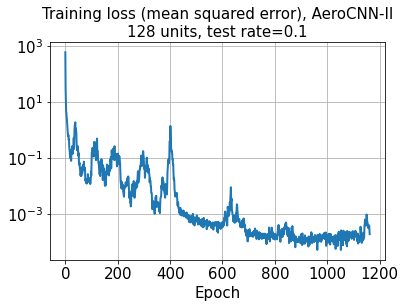

In [29]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error), AeroCNN-II\n{0} units, test rate={1}'.format(n_units, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

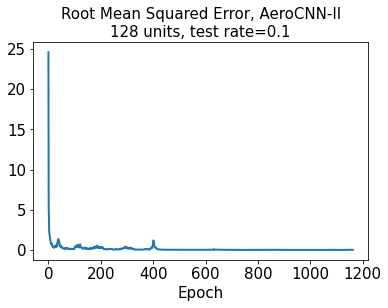

In [30]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error, AeroCNN-II\n{0} units, test rate={1}'.format(n_units, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

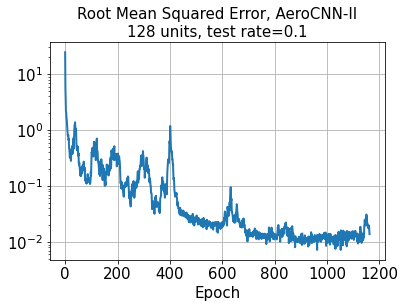

In [31]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error, AeroCNN-II\n{0} units, test rate={1}'.format(n_units, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [32]:
train_results = model.evaluate(x_train, y_train)

5/5 [==============================] - 0s 8ms/step - loss: 1.3465e-04 - rmse: 0.0116


In [33]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 38ms/step - loss: 0.0098 - rmse: 0.0989


In [34]:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)

1/1 [==============================] - 0s 15ms/step


In [35]:
model_directory = "D:\\TrainedModels\\20221119"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221119steadyValidation_AeroCNN_II_test"+str(test_rate)+ "_" + str(n_units) +"units_normalized.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [36]:
error_train_abs = np.abs(decoded_train - y_train)

In [37]:
error_test_abs = np.abs(decoded_test - y_test)

In [38]:
os.chdir(storage_dir)

In [39]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.013585046319750996


In [40]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.11433770123100374


In [41]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

0.20324905300103766


In [42]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.011335832926359465


In [43]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

1.1596983774592984


In [44]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.10830342757286801


In [45]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [46]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [47]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [48]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [49]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [50]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

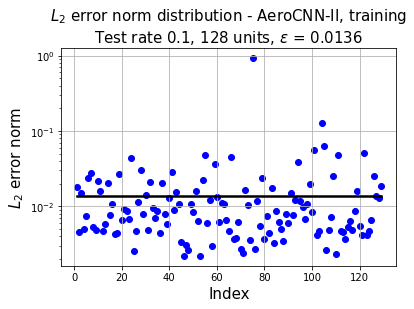

In [51]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\nTest rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

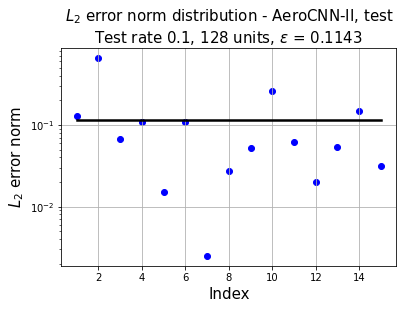

In [52]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\nTest rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                     n_units,
                                                                                                                     l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

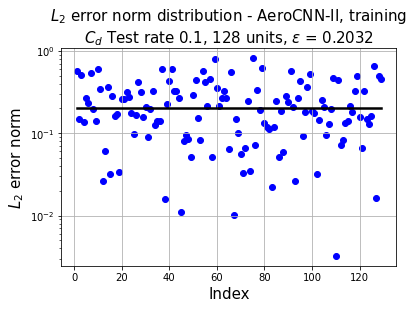

In [53]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\n$C_d$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

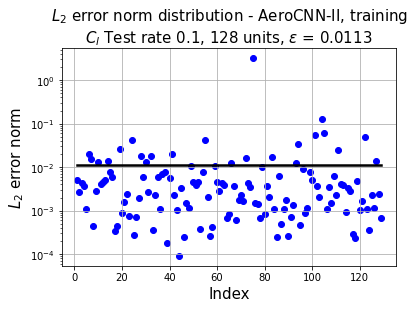

In [54]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\n$C_l$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

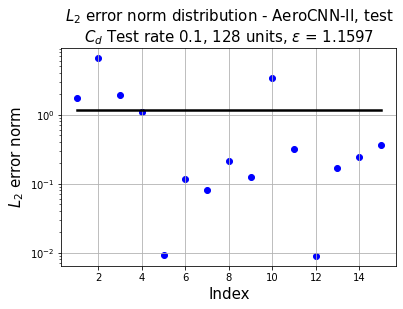

In [55]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\n$C_d$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                           n_units,
                                                                                                                           l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

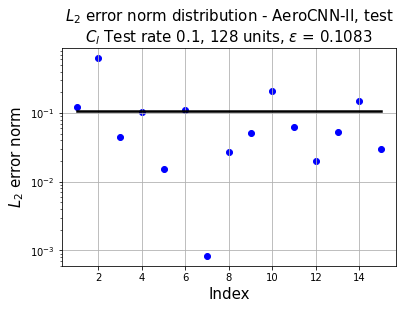

In [56]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\n$C_l$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                           n_units,
                                                                                                                           l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()